# CBIR 

In [155]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
from google.colab.patches import cv2_imshow

We define the following functions to display the results:

In [156]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=reverse)[:n]  # Sort and keep the top 5 most similar
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("The value of n must be greater than 0.")
        return

    if n > len(sorted_indexes):
        print(f"There are only {len(sorted_indexes)} images in the list. Showing all.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        folder = (sorted_indexes[i][0])
        img_number = (sorted_indexes[i][1])
        path = images_path[(folder, img_number)]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].axis('off')
        title = f'{folder}_{img_number}'
        axs[i].set_title(title)

    plt.show()


# We store the paths of all the images

In [157]:
n_imgs = 100
folders = ["bus-n04487081", "nails-n03804744", "car-n02814533", "collar-n03814639", "plunger-n03970156",
           "cats-n02123394", "monkey-n02480495", "bridges-n04532670", "chair-n04099969", "dog-n02099601",
           "duck-n01855672", "pizza-n07873807", "sea-n09428293", "ipod-n03584254", "banana-n07753592", "gas_mask-n03424325",
           "bow_tie-n02883205", "fly-n02190166", "ice_cream-n07615774", "cannon-n02950826"]
len(folders)


In [158]:
len(folders)

20

In [159]:
def get_images_path(folders, n_imgs):
    images_path = {}
    for folder in folders:
        for i in range(n_imgs):
            images_path[(folder[-7:], str(i))] = f'/content/drive/MyDrive/dataset/{folder}/{folder[-9:]}_{str(i)}.JPEG'
            # images_path[(folder[-7:], str(i))] = f'./dataset/{folder}/{folder[-9:]}_{str(i)}.JPEG'
    return images_path # Returns a dictionary where the key is (folder, id), and the values are the paths


In [160]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

# How Our Method works

In [161]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.show()
gray_im = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im, cmap='gray')
plt.show()

In [162]:
gray_im = np.float32(gray_im)
dst = cv2.cornerHarris(gray_im, 2, 3, 0.04)

# Dilate the corners for better visualization
# dst = cv2.dilate(dst, None)

# Highlight corners in the color image
new_img[dst > 0.1 * dst.max()] = [0, 0, 255]  # Red color for corners

larger_image = cv2.resize(new_img, None, fx=5, fy=5)

# Display the image with highlighted corners
cv2_imshow(larger_image)
# cv2.imshow('Harris Corners', result_image)


The function returns a matrix of corner values that indicates the measure of the Harris response at each pixel of the input image.

The matrix returned by cv2.cornerHarris() will have the same size as the input image and contain values representing the measure of the corner at each pixel. Higher values in this matrix indicate regions of the image where corners are located.

In this case, it returns a matrix of 64 values.

## We apply the  corner detector to all our images

In [163]:
if os.path.exists('HARRIS_descriptors.npy'):
    corners = np.load('HARRIS_descriptors.npy')
else:

    corners = np.empty((0,66))
    for idx in images_path:
        gray_im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2GRAY)
        gray_im = np.float32(gray_im)
        dst = cv2.cornerHarris(gray_im,2,3,0.04)
        corner_arr = np.array(dst)
        mn = corner_arr.mean()
        std = corner_arr.std()
        corner_arr = (corner_arr - mn) / std
        if np.any(corner_arr):
            corner_arr = np.insert(corner_arr, 0, idx[1], axis=1)
            corner_arr = np.insert(corner_arr, 0, idx[0], axis=1)
            corners =  np.vstack([corners, corner_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen
    np.save('HARRIS_descriptors', corners)


In [164]:
corners.shape

(128000, 66)

# We train KNN

In [165]:
n_neighbors = 1000
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

descriptors_train = corners[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean', n_neighbors=1000)

## We obtain the most similar images to a new image

In [166]:
counts = {}
print(counts)
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
gray_im_new = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
new_corners = cv2.cornerHarris(gray_im_new,2,3,0.04)

for descriptor in new_corners:
    descriptor = descriptor.reshape(1, -1)
    mn = descriptor.mean()
    std = descriptor.std()
    descriptor = (descriptor - mn) / std
    distance, indice = knn.kneighbors(descriptor, n_neighbors=100)
    for idx in indice[0]:
        carpeta = str(int(corners[idx,0]))
        num_img = str(int(corners[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1

{}


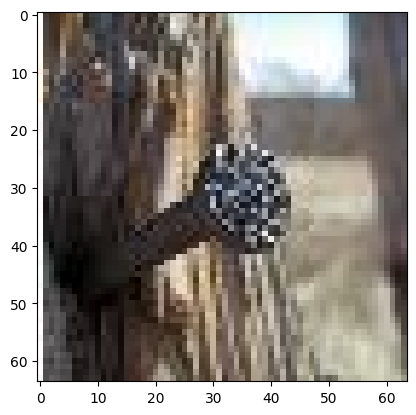

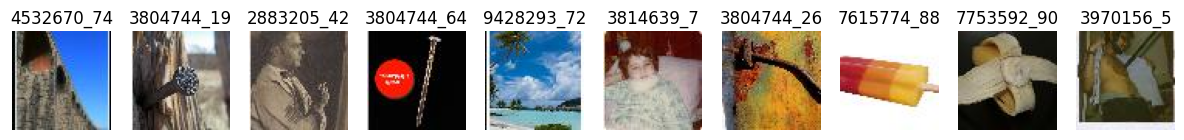

In [ ]:
plt.imshow(new_img)
idx_similar = get_n_similar(10, counts, 1)
display_n_similar(idx_similar, 10)